This document includes code to test and document various pygcdl functions. Before running the code in this document, run the code in "sample_data/create_spatial_data.ipynb" to create the data files that this code uses.

- Part 0: Load packages and create pygcdl object
- Part 1: Upload geometry objects
  - Part 1.1: Upload files
  - Part 1.2: Upload geopandas geodataframes
  - Part 1.3: Specifying clipping coordinates
- Part 2: Specifying datasets and variables
- Part 3: Specifying temporal data and additional parameters
- Part 4: Download and visualize data

### Part 0: Load packages and create pygcdl object

In [1]:
# First we import the necessary libraries
import sys
import pygcdl
import geopandas as gpd
import os
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
import importlib
import tempfile
import pprint
import rioxarray
import matplotlib.pyplot as plt
import math
importlib.reload(pygcdl)
import json

In [2]:
# Create the pygcdl object
# url_base set for local development
# Remove url_base for Ceres development and testing
pygcdl_obj = pygcdl.PyGeoCDL(url_base="http://127.0.0.1:8000")

### Part 1: Upload geometries

We can upload a geometry as:
- A geojson file
- A shapefile
- A zipfile containing shapefile files
- A csv file (point data only?)
- A geopandas dataframe

The GCDL can only handle generate polygon subsets of single polygons, or multipolygon objects that contain only one polygon. If the user attempts to upload a <i>geopandas dataframe</i> that contains multiple polygons, then pygcdl calculates the ratio between the area of the union of polygons, and the area of the convex hull. If the union of polygons covers at least 80% of the area of the convex hull, then the pygcdl uploads the convex hull. Otherwise, pygcdl uploads each polygon individually, and returns a list of GUIDs.

<b>Known GCDL issue:</b> When the user uploads a file, the file contents are not checked. So, it is possible for a user to upload a multipolygon file without any errors or warnings, and then run into errors when trying to use that GUID to download a polygon subset. GCDL support for multipolygons is an open [issue](https://github.com/stuckyb/gcdl/issues/120). We advise against uploading multipolygon files with pygcdl, and instead encourage users to load multipolygons into geopandas dataframes to upload them with pygcdl.

Here is a summary of the geometry objects we upload (both files and geodataframes), and the name of the variable we will use to store the resulting GUID.

| Geometry source | Geometry description | GUID variable name |
| :- | :- | :- |
| yolo_county.zip | Zipped shapefile of yolo county boundary polygon | yolo_county_zip_guid |
| yolo_county.shp | Same as above, only not in a zip file | yolo_county_shp_guid |
| yolo_county.geojson | Same as above, only saved in geojson format | yolo_county_geojson_guid |
| county_centroids.zip | Point data representing the centroid of each county in CA | county_centroids_zip_guid |
| county_centroids.csv | Same data as above, x and y values stored as a csv. No geographic metadata included. | county_centroids_csv_guid |
| yolo_county geodataframe, loaded from yolo_county.zip | Same as yolo_county.zip | yolo_gdf_guid |
| yolo_sac_county geodataframe, loaded from yolo_sac_counties.zip | Boundaries of Yolo and Sacramento counties, adjacent polygons | yolo_sac_gdf_guid |
| ventura_county geodataframe, loaded from ventura_county.zip | Boundaries of Ventura county multipolygon data, includes islands | ventura_gdf_guid |


### Part 1.1: Upload geometry files

In [3]:
# Specify location of sample data files
sample_data_dir = Path("sample_data/sample_geoms")

In [4]:
# Upload zipped shapefiles of Yolo county boundaries
yolo_county_zip_guid = pygcdl_obj.upload_geometry(sample_data_dir / "yolo_county.zip")
print(yolo_county_zip_guid)

5cc2fed2-fdd5-496b-9dc1-a2d233124aa5


Users can also upload shapefiles by pointing directly to a .shp file, instead of a zip file. Pygcdl finds associated files (ie .shp, .cpg, etc) and creates a zip file containing all such necessary files. If not all files are present in the same directory as the .shp file, then an error is thrown.

In [5]:
yolo_county_shp_guid = pygcdl_obj.upload_geometry(sample_data_dir / "yolo_county.shp")
print(yolo_county_shp_guid)

84872d4a-9d6d-4c7a-b68f-7b76c5127055


Now, we will show what happens if you attempt to upload a polygon .shp file that doesn't have the associated files in the same directory. Here, we attempt to upload the file at `sample_data/sample_geoms/lonely_shp/single_polygon.shp`, even though there are no associated files in this directory.

In [6]:
# Attempt to upload the .shp file without associated files, and observe the error produced by pygcdl
# CAUSES AN ERROR - uncomment to run and see error
#lonely_shp_path = Path(sample_data_dir / "lonely_shp" / "yolo_county.shp")
#faulty_guid = pygcdl_obj.upload_geometry(lonely_shp_path)

In [7]:
# Upload polygon geojson file
yolo_county_geojson_guid = pygcdl_obj.upload_geometry(sample_data_dir / "yolo_county.geojson")
print(yolo_county_geojson_guid)

090af74e-9419-4e34-9233-b40793d994f5


In [8]:
# Upload a points shapefile zipfile
county_centroids_zip_guid = pygcdl_obj.upload_geometry(sample_data_dir / "county_centroids.zip")
print(county_centroids_zip_guid)

aacacf0a-3ab1-4236-81d3-9436612d0f7e


In [9]:
# Upload a points csv file
county_centroids_csv_guid = pygcdl_obj.upload_geometry(sample_data_dir / "county_centroids.csv")
print(county_centroids_csv_guid)

3d294e6a-b637-4f06-bf04-e0f3ed25f9a7


### Part 1.2: Upload geopandas geodataframes

Now, we will show how to upload geometries as geopandas dataframes. We will load `yolo_county.shp`, `yolo_sac_counties`, and `ventura_county.shp` into geopandas dataframes, and then apply the `upload_geometry()` objects on these geodataframes. First, lets load our data into geopandas and view the polygons.

You will see here that the multipolygon data will return multiple guids instead of just one. This is because for multipolygon data, pygcdl calculates the ratio between the union of the multi/polygons and the convex hull of the multi/polygons. If the ratio is over 80%, then the convex hull is uploaded. If the ratio is below 80%, then each polygon is uploaded individually, each returning its own GUID.

In [10]:
# Read in files
yolo_county = gpd.read_file(sample_data_dir / "yolo_county.zip")
yolo_sac_counties = gpd.read_file(sample_data_dir / "yolo_sac_counties.zip")
ventura_county = gpd.read_file(sample_data_dir / "ventura_county.zip")

<Axes: >

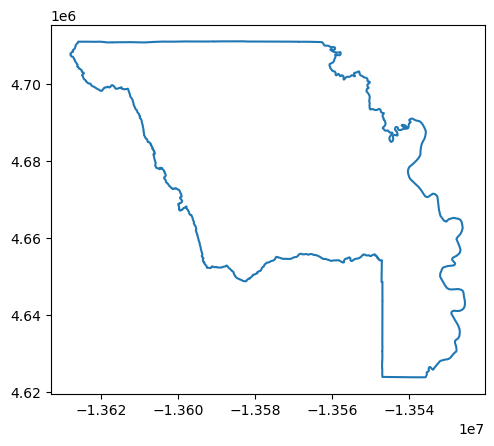

In [11]:
yolo_county.boundary.plot()

<Axes: >

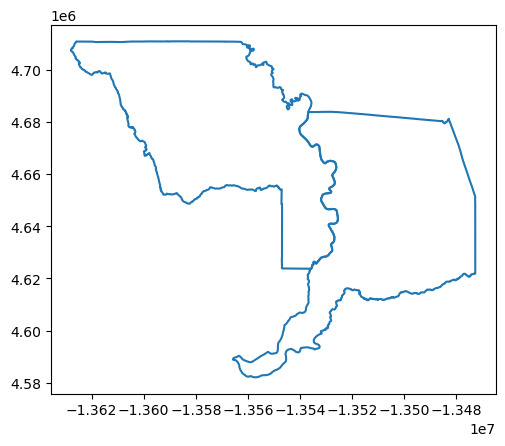

In [12]:
yolo_sac_counties.boundary.plot()

<Axes: >

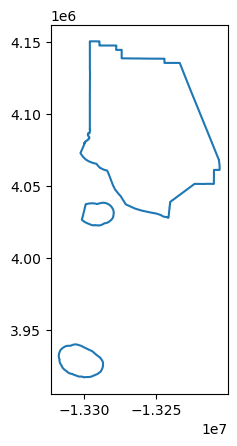

In [13]:
ventura_county.boundary.plot()

You can see that these three geometries have different properties. Yolo county is just one polygon. The Yolo/Sac counties data contains two adjacent polygons. The Ventura data contains one row of multipolygon data because Ventura county has islands. As of the time of writing, GCDL cannot handle multipolygon subsetting requests. Here's how pygcdl handles uploads of data that either includes multiple rows of polygon data, or at least one multipolygon row with more than one polygon:
- If the union of the polygons is one polygon, upload the union
- Else, calculate the ratio of the area of the union of the polygons divided by the area of the [convex hull](https://www.geeksforgeeks.org/convex-hull-algorithm/) of the polygons.
   - If the ratio is over 80%, upload the convex hull
   - Else, iterate through each polygon in the set, and upload each individually, generating a unique GUID for each component polygon. Here, upload_geometry() returns a list of GUIDs.
   
Next, we calculate the union to convex hull ratios.

In [14]:
# Define a function to calculate the union to convex hull ratio
def union_convex_hull_ratio(gdf = gpd.GeoDataFrame):
    union_polygon = gdf.unary_union
    union_area = union_polygon.area
    convex_hull_area = union_polygon.convex_hull.area
    ratio = round(union_area / convex_hull_area, ndigits=3)
    return ratio

In [15]:
print("Yolo county ratio: ", union_convex_hull_ratio(yolo_county))
print("Yolo/Sac counties ratio: ", union_convex_hull_ratio(yolo_sac_counties))
print("Ventura county ratio: ", union_convex_hull_ratio(ventura_county))

Yolo county ratio:  0.778
Yolo/Sac counties ratio:  0.678
Ventura county ratio:  0.53


When we upload these geometries, we expect the yolo county and yolo/sac counties geometries to return a single GUID, and we expect the Ventura county geometry to return a list of three GUIDs since Ventura county has three constituent polygons and a union to convex hull ratio of 0.53.

In [16]:
yolo_gdf_guid = pygcdl_obj.upload_geometry(yolo_county)
print(yolo_gdf_guid)

408193f5-45ed-4b1c-b0af-cb5350ce0cbc


In [17]:
yolo_sac_gdf_guid = pygcdl_obj.upload_geometry(yolo_sac_counties)
print(yolo_sac_gdf_guid)

7c4659f1-1914-43a5-9057-a3e3c759d017


In [18]:
ventura_gdf_guid = pygcdl_obj.upload_geometry(ventura_county)
print(ventura_gdf_guid)

['437bf791-2297-4e88-afd6-0ef46df72855', '8e0a0c88-cf30-4e11-814e-0f7a18794ef5', 'c07c39ee-b742-41f7-af63-60128d65a4cd']


### Part 1.3: Specifying clipping coordinates
Instead of geometry objects or files, the user can instead specify clipping coordinates as a string. This can take either of these two forms:

1) Specifying bounding box coordinates: </br>
    a) "(upper_left_x,upper_left_y),(lower_right_x,lower_right_y)" </br>
    b) "upper_left_x,upper_left_y;lower_right_x,lower_right_y" </br>
2) Specifying a list of polygon verticies. GCDL will close the polygon if the first set of coords doesn't match the last. </br>
    a) "(x1,y1),(x2,y2),..." </br>
    b) "x1,y1;x2,y2;..."
    
NOA: Test if it works to use any two opposite coordinates. In theory both coords_str1 and coords_str2 should both work because polygons can be build clockwise or counterclockwise.

In [19]:
# Create coordinate strings based on the bounding box coordinates of our yolo_county geodataframe object
minx, miny, maxx, maxy = yolo_county.total_bounds
coords_str1 = "(" + str(minx) + "," + str(miny) + "),(" + str(maxx) + "," + str(maxy) + ")"
coords_str2 = "(" + str(minx) + "," + str(maxy) + "),(" + str(maxx) + "," + str(miny) + ")"
print(coords_str1)
print(coords_str2)

(-13627961.5316,4623744.591300003),(-13525432.807799999,4711067.952500001)
(-13627961.5316,4711067.952500001),(-13525432.807799999,4623744.591300003)


### Part 2: Specifying datasets and variables

First, we can see which datasets are available with the `list_datasets()` method.

In [20]:
print(pygcdl_obj.list_datasets())

{'DaymetV4': 'Daymet Version 4', 'GTOPO30': 'Global 30 Arc-Second Elevation', 'MODIS_NDVI': 'MODIS NDVI Data, Smoothed and Gap-filled, for the Conterminous US: 2000-2015', 'NASS_CDL': 'NASS Cropland Data Layer', 'NLCD': 'National Land Cover Database', 'PRISM': 'PRISM', 'RAPV3': 'Rangeland Analysis Platform Version 3', 'SMAP-HB1km': 'SMAP HydroBlocks - 1 km', 'Soilgrids250mV2': 'SoilGrids — global gridded soil information', 'VIP': 'Vegetation Index and Phenology (VIP) Vegetation Indices Daily Global 0.05Deg CMG V004'}


Next, we can get more information about one specific dataset with the `get_dataset_info()` method.

In [21]:
print(pygcdl_obj.get_dataset_info("MODIS_NDVI")['crs']['wkt'])

PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["Unknown based on Normal Sphere (r=6370997) ellipsoid",ELLIPSOID["Normal Sphere (r=6370997)",6370997,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],CONVERSION["unknown",METHOD["Lambert Azimuthal Equal Area (Spherical)",ID["EPSG",1027]],PARAMETER["Latitude of natural origin",45,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-100,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["(E)",east,ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["(N)",north,ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]


We can list just the variables available in a given dataset as follows.

In [22]:
print(pygcdl_obj.get_dataset_info("PRISM")["vars"])

{'ppt': 'total precipitation (rain+melted snow)', 'tmean': 'mean temperature (mean of tmin and tmax)', 'tmin': 'minimum temperature', 'tmax': 'maximum temperature', 'tdmean': 'mean dew point temperature', 'vpdmin': 'minimum vapor pressure deficit', 'vpdmax': 'maximum vapor pressure deficit'}


Now let's take a look at how we specify the datasets and variables we would like to use. We can do this with a pandas dataframe, a dict, or a matrix as follows.

In [23]:
# Specify datasets and variables as a pandas dataframe
dsvars1 = pd.DataFrame(
    [["PRISM", "ppt"], ["PRISM", "tmean"], ["MODIS_NDVI", "NDVI"]], 
    columns=["dataset", "variable"])
print(dsvars1)

      dataset variable
0       PRISM      ppt
1       PRISM    tmean
2  MODIS_NDVI     NDVI


In [24]:
# Specify datasets and variables as a dict.
# Dataset names are keys, and lists of datasets are values
dsvars2 = {"PRISM":["ppt", "tmean"], "MODIS_NDVI":["NDVI"]}
print(dsvars2)

{'PRISM': ['ppt', 'tmean'], 'MODIS_NDVI': ['NDVI']}


In [25]:
# Specify datasets and variables as a list (of lists)
# Here, we have a list of [dataset, variable] pairs
# NOA! FUTURE TEST: Does this work with (dataset, variable) tuples
dsvars3 = [["PRISM", "ppt"],["PRISM", "tmean"], ["MODIS_NDVI", "NDVI"]]
print(dsvars3)

[['PRISM', 'ppt'], ['PRISM', 'tmean'], ['MODIS_NDVI', 'NDVI']]


In [26]:
# Specify datasets and variables as a numpy array
# Each row is in the form [dataset, variable]
dsvars4 = np.array([["PRISM", "ppt"],["PRISM", "tmean"], ["MODIS_NDVI", "NDVI"]])
print(dsvars4)

[['PRISM' 'ppt']
 ['PRISM' 'tmean']
 ['MODIS_NDVI' 'NDVI']]


### Part 3: Specifying temporal data and additional parameters

Next, we specify our date data and grain method. We can specify our dates by either specifying dates in a single string, or by specifying years, months, and days separately.

#### Specifying dates with datestrings:
- Individual dates are expressed as:
  - "YYYY" for annual grain
  - "YYYY-M" or "YYYY-MM" for monthly grain
  - "YYYY-M-D", "YYYY-MM-D" or "YYYY-MM-DD" for daily grain
- A datestring contains one or more dates
- All of the dates listed in a date string must be of the same grain.
- Ranges of dates can be specified with a colon as in "DSTR:DSTR"
- Multiple dates can be listed, separated by commas as in "DSTR,DSTR"
- For example, "2000-01-01:2000-01-31,2001-01-01:2000-01-31" specifies each day in January of 2000 and 2001

#### Specifying years, months, and days individually
- Years, months, and days can be specified as lists or ranges, just like datestrings (ie years = "2008,2010:2012")
- The "years" value must be specified.
- If the user specifies the "days" but not "months", then the value for "days" represents the number of days into the year, which can be a value from 1 to either 365 or 366, depending on the year.
- For example, specifying `years=2000:2003` and `months=1,7` would request data from January and July of each year from 2000 to 2003.

#### Date grain_method options

Some datasets contain daily data, some monthly, some yearly, and some datasets don't have a temporal component. If the requested date grain is available, GCDL will return data of that grain. If it is not available, the grain_method is used to determine what alternative date grain the user would accept. Here are the grain_method options available.

- <b>"strict":</b> User will only accept the requested date grain. If date grain is not available, GCDL will throw an error.
- <b>"skip":</b> If date grain is not available, do not return data for that dataset and variable. Will not throw an error.
- <b>"finer":</b> User will accept the requested date grain, or a finer date grain. Finer grains attempted in order from largest to smallest. Ex: if user requests annual date grain and the finer grain method, and annual data is not available, GCDL will first see if monthly data is available, and if not will then try daily data.
- <b>"coarser":</b> User will accept the requested date grain, or a coarser date grain. Coarser grains attempted in order from smallest to largest.
- <b>"any":</b> User will accept any alternative date grain. Alternative grains are attempted from largest to smallest.

In [27]:
# Specify various date and grain combinations.
date_grain_dict1 = {"years":"2008", "months":"7:8", "grain_method":"any"}
date_grain_dict2 = {"dates":"2008-07,2008-08", "grain_method":"strict"}
date_grain_dict3 = {"years":"2008", "days":"200:209", "grain_method":"coarser"}

Next, we specify our spatial resolution. This is in units of the target crs. The target crs will be:
- The t_crs parameter set by the user, if specified
- Else: the crs of the geometry the user uploaded, if that crs exists (may not exist if user uploads csv or specifies clipping coordinates)
- Else: the crs of the first dataset requested

Our target crs is EPSG:3857, which is in units of meters. So, our spatial resolution will specify the size of a pixel in units of meters.

In [28]:
spat_res = 1000 # meters

Lastly, we need to specify the resampling method for polygon data, and the interpolation method for point data. 

The resampling method describes how to convert data from one grid to another. This is useful when we need to transform the CRS or the resolution of our raster data. Available resampling methods include "nearest", "bilinear", "cubic", "cubic-spline", "lanczos", "average", or "mode". Default is "nearest". For categorical data, only "nearest" and "mode" are applicable, and other specifications will cause errors. You can learn more about resampling methods [here](https://rasterio.readthedocs.io/en/latest/topics/resampling.html).

The interpolation method describes how to extract values at points for gridded data. Available interpolation methods include "nearest" and "linear". Default is "nearest". For categorical data, only "nearest" is applicable, and other specifications ("linear") will cause errors. You can learn more about interpolation [here](https://docs.xarray.dev/en/latest/user-guide/interpolation.html).

In [29]:
resample_method = "bilinear" # for polygon requests
interp_method = "nearest" # for point requests

### Part 4: Downloading and data

In [36]:
print(date_grain_dict1)
print(date_grain_dict1["years"])

{'years': '2008', 'months': '7:8', 'grain_method': 'any'}
2008


In [37]:
dir_test = Path.cwd().as_posix()
print(type(dir_test))

<class 'str'>


Download test #1
- Geometry = yolo county bounds from uploaded zip file, yolo_county_zip_guid
- Dsvars = dsvars1, data specified as a pandas df
- Date data = date_grain_dict1, years = 2008, months = 7:8, grain = any

DEBUG

[WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpxus127gm/MODIS_NDVI_NDVI_2008-07-07.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpxus127gm/MODIS_NDVI_NDVI_2008-07-15.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpxus127gm/MODIS_NDVI_NDVI_2008-07-23.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpxus127gm/MODIS_NDVI_NDVI_2008-07-31.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpxus127gm/MODIS_NDVI_NDVI_2008-08-08.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpxus127gm/MODIS_NDVI_NDVI_2008-08-16.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpxus127gm/MODIS_NDVI_NDVI_2008-08-24.tif')]
[WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpxus127gm/PRISM_ppt_2008-07.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpxus127gm/PRISM_ppt_2008-08.tif')]
[WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpxus127gm/PRISM_tmean_2008-07.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/t

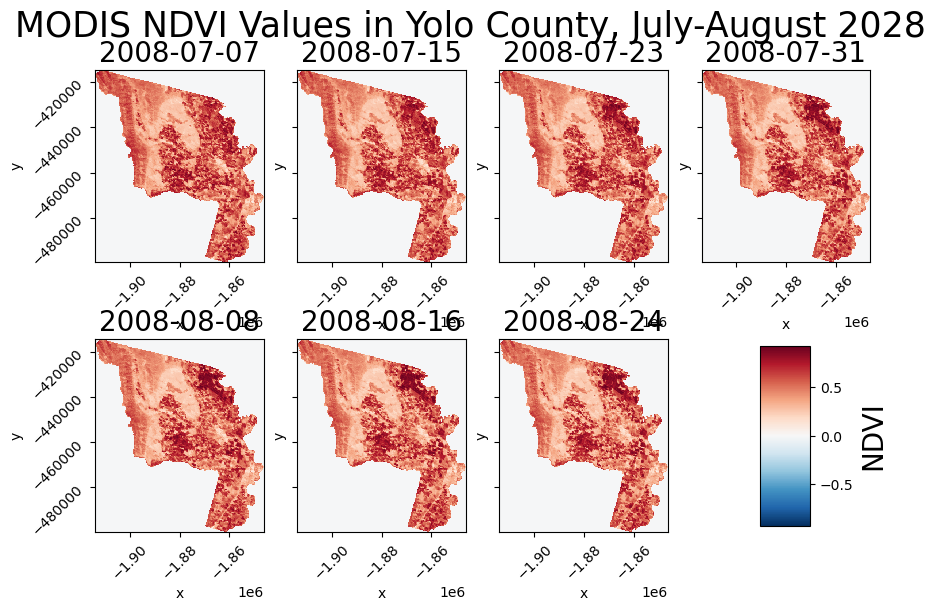

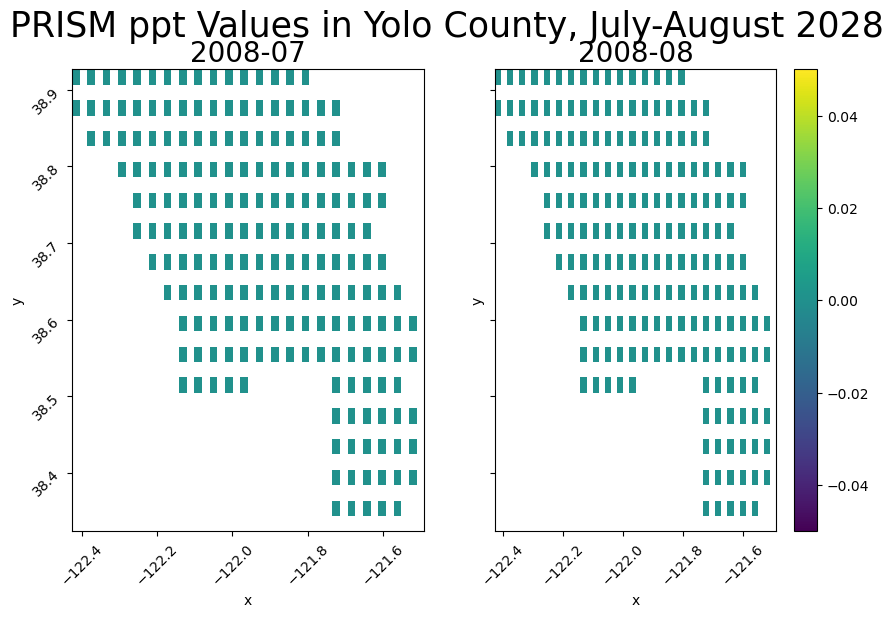

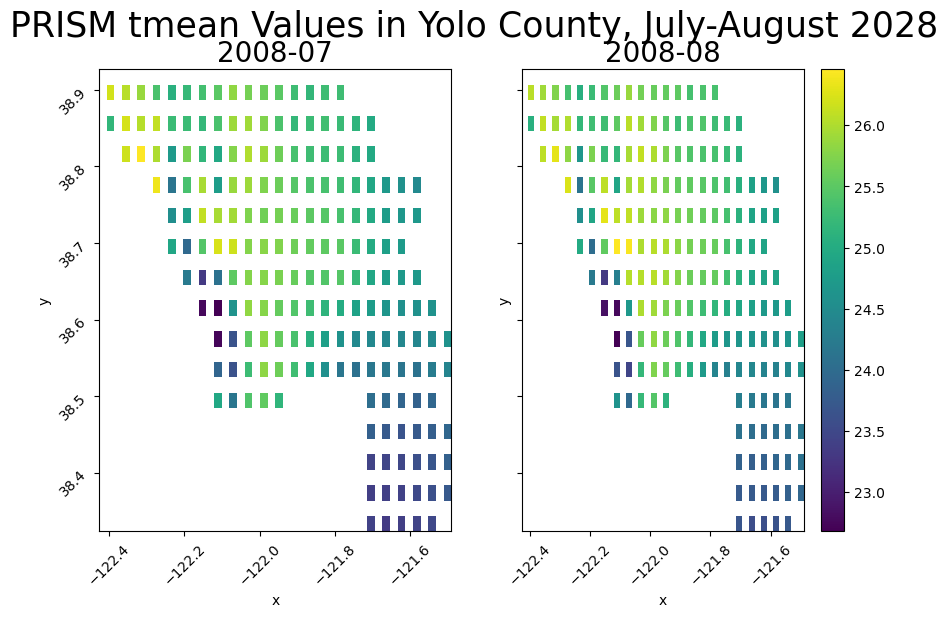

In [42]:
geom_data = yolo_county_zip_guid
dsvars = dsvars1
date_data = date_grain_dict1

with tempfile.TemporaryDirectory() as tf:
    output_files = pygcdl_obj.download_polygon_subset(
        dsvars=dsvars1, 
        t_geom=geom_data,
        dsn=tf,
        **date_data
    )
    modis_file_paths = [Path(f) for f in output_files if "MODIS" in f]
    ppt_file_paths = [Path(f) for f in output_files if "PRISM" in f and "ppt" in f]
    tmean_file_paths = [Path(f) for f in output_files if "PRISM" in f and "tmean" in f]
    
    print(modis_file_paths)
    print(ppt_file_paths)
    print(tmean_file_paths)

    # Read in MODIS NDVI data.
    modis_image_stack = [
        rioxarray.open_rasterio(k, mask_and_scale=True) for k in modis_file_paths
    ]
    
    num_images = len(modis_image_stack)
    
    ndvi_layer_names = [
        str(path).split("NDVI_NDVI_")[1].split(".tif")[0] for path in modis_file_paths
    ]
    
    # Plot the MODIS NDVI data.
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (10, 6), sharey=True)
    fig.suptitle("MODIS NDVI Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = modis_image_stack[i].plot(ax=axs[math.floor(i/4), i%4], add_colorbar=False)
        axs[math.floor(i/4), i%4].set_title(ndvi_layer_names[i], fontsize=20)
        axs[math.floor(i/4), i%4].tick_params(labelrotation=45)
    axs[1,3].axis("off")
    label_axis = fig.add_axes([0.79, 0.12, 0.05, 0.3])
    cbar = fig.colorbar(im, cax=label_axis)
    cbar.set_label(label="NDVI", fontsize=20)
    
    # Read in PRISM ppt data.
    ppt_image_stack = [
        rioxarray.open_rasterio(k, masked=True) for k in ppt_file_paths
    ]
    
    num_images = len(ppt_image_stack)
    
    ppt_layer_names = [
        str(path).split("PRISM_ppt_")[1].split(".tif")[0] for path in ppt_file_paths
    ]
    
    # Plot the PRISM ppt data.
    
    fig, axs = plt.subplots(ncols=2, figsize = (10, 6), sharey=True)
    fig.suptitle("PRISM ppt Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = ppt_image_stack[i].plot(ax=axs[i], add_colorbar=False)
        axs[i].set_title(ppt_layer_names[i], fontsize=20)
        axs[i].tick_params(labelrotation=45)
    fig.colorbar(im)
    
    # Read in PRISM tmean data.
    tmean_image_stack = [
        rioxarray.open_rasterio(k, masked=True) for k in tmean_file_paths
    ]
    
    tmean_crs = tmean_image_stack[0].rio.crs
    print("tmean CRS: ", tmean_crs)
    
    num_images = len(tmean_image_stack)
    
    tmean_layer_names = [
        str(path).split("PRISM_tmean_")[1].split(".tif")[0] for path in tmean_file_paths
    ]

    # Plot the PRISM tmean data.
    
    fig, axs = plt.subplots(ncols=2, figsize = (10, 6), sharey=True)
    fig.suptitle("PRISM tmean Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = tmean_image_stack[i].plot(ax=axs[i], add_colorbar=False)
        axs[i].set_title(tmean_layer_names[i], fontsize=20)
        axs[i].tick_params(labelrotation=45)
    fig.colorbar(im)

    # Close xarray images so the temporary directory can close without errors
    for image in modis_image_stack:
        image.close()
    for image in ppt_image_stack:
        image.close()
    for image in tmean_image_stack:
        image.close()

In [43]:
# Same as above, but with geojson file
geom_data = yolo_county_geojson_guid
dsvars = dsvars1
date_data = date_grain_dict1

with tempfile.TemporaryDirectory() as tf:
    output_files = pygcdl_obj.download_polygon_subset(
        dsvars=dsvars1, 
        t_geom=geom_data,
        dsn=tf,
        **date_data
    )
    modis_file_paths = [Path(f) for f in output_files if "MODIS" in f]
    ppt_file_paths = [Path(f) for f in output_files if "PRISM" in f and "ppt" in f]
    tmean_file_paths = [Path(f) for f in output_files if "PRISM" in f and "tmean" in f]
    
    print(modis_file_paths)
    print(ppt_file_paths)
    print(tmean_file_paths)

    # Read in MODIS NDVI data.
    modis_image_stack = [
        rioxarray.open_rasterio(k, mask_and_scale=True) for k in modis_file_paths
    ]
    
    num_images = len(modis_image_stack)
    
    ndvi_layer_names = [
        str(path).split("NDVI_NDVI_")[1].split(".tif")[0] for path in modis_file_paths
    ]
    
    # Plot the MODIS NDVI data.
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (18, 10), sharey=True)
    fig.suptitle("MODIS NDVI Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = modis_image_stack[i].plot(ax=axs[math.floor(i/4), i%4], add_colorbar=False)
        axs[math.floor(i/4), i%4].set_title(ndvi_layer_names[i], fontsize=20)
        axs[math.floor(i/4), i%4].tick_params(labelrotation=45)
    axs[1,3].axis("off")
    label_axis = fig.add_axes([0.79, 0.12, 0.05, 0.3])
    cbar = fig.colorbar(im, cax=label_axis)
    cbar.set_label(label="NDVI", fontsize=20)
    
    # Read in PRISM ppt data.
    ppt_image_stack = [
        rioxarray.open_rasterio(k, masked=True) for k in ppt_file_paths
    ]
    
    num_images = len(ppt_image_stack)
    
    ppt_layer_names = [
        str(path).split("PRISM_ppt_")[1].split(".tif")[0] for path in ppt_file_paths
    ]
    
    # Plot the PRISM ppt data.
    
    fig, axs = plt.subplots(ncols=2, figsize = (14, 8), sharey=True)
    fig.suptitle("PRISM ppt Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = ppt_image_stack[i].plot(ax=axs[i], add_colorbar=False)
        axs[i].set_title(ppt_layer_names[i], fontsize=20)
        axs[i].tick_params(labelrotation=45)
    fig.colorbar(im)
    
    # Read in PRISM tmean data.
    tmean_image_stack = [
        rioxarray.open_rasterio(k, masked=True) for k in tmean_file_paths
    ]
    
    num_images = len(tmean_image_stack)
    
    tmean_crs = tmean_image_stack[0].rio.crs
    print("tmean CRS: ", tmean_crs)
    
    tmean_layer_names = [
        str(path).split("PRISM_tmean_")[1].split(".tif")[0] for path in tmean_file_paths
    ]
    
    # Plot the PRISM tmean data.
    
    fig, axs = plt.subplots(ncols=2, figsize = (14, 8), sharey=True)
    fig.suptitle("PRISM tmean Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = tmean_image_stack[i].plot(ax=axs[i], add_colorbar=False)
        axs[i].set_title(tmean_layer_names[i], fontsize=20)
        axs[i].tick_params(labelrotation=45)
    fig.colorbar(im)

    # Close xarray images so the temporary directory can close without errors
    for image in modis_image_stack:
        image.close()
    for image in ppt_image_stack:
        image.close()
    for image in tmean_image_stack:
        image.close()

Status_code:  500


Exception: Internal Server Error

In [44]:
dsvars_debug = pd.DataFrame(
    [["PRISM", "ppt"], ["PRISM", "tmean"]], 
    columns=["dataset", "variable"])
print(dsvars_debug)

  dataset variable
0   PRISM      ppt
1   PRISM    tmean


[WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpnxsn3i6h/PRISM_ppt_2008-07.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpnxsn3i6h/PRISM_ppt_2008-08.tif')]
[WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpnxsn3i6h/PRISM_tmean_2008-07.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpnxsn3i6h/PRISM_tmean_2008-08.tif')]
tmean CRS:  EPSG:4269


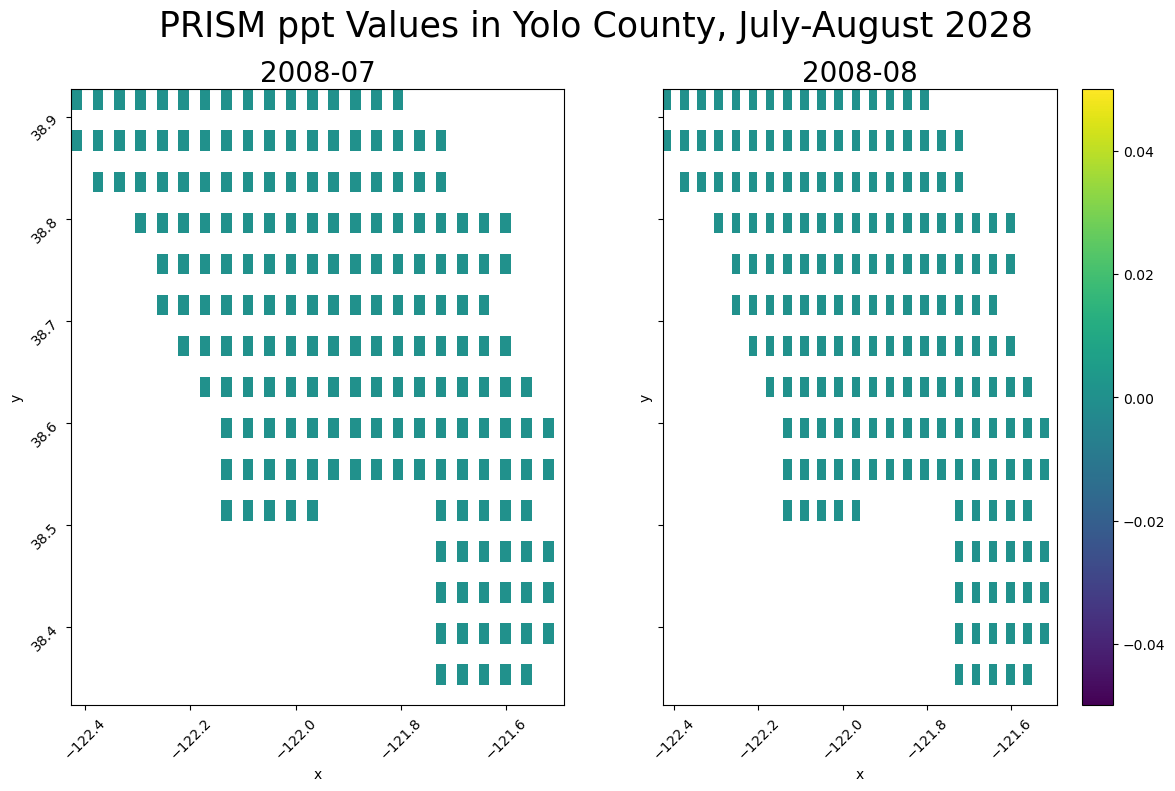

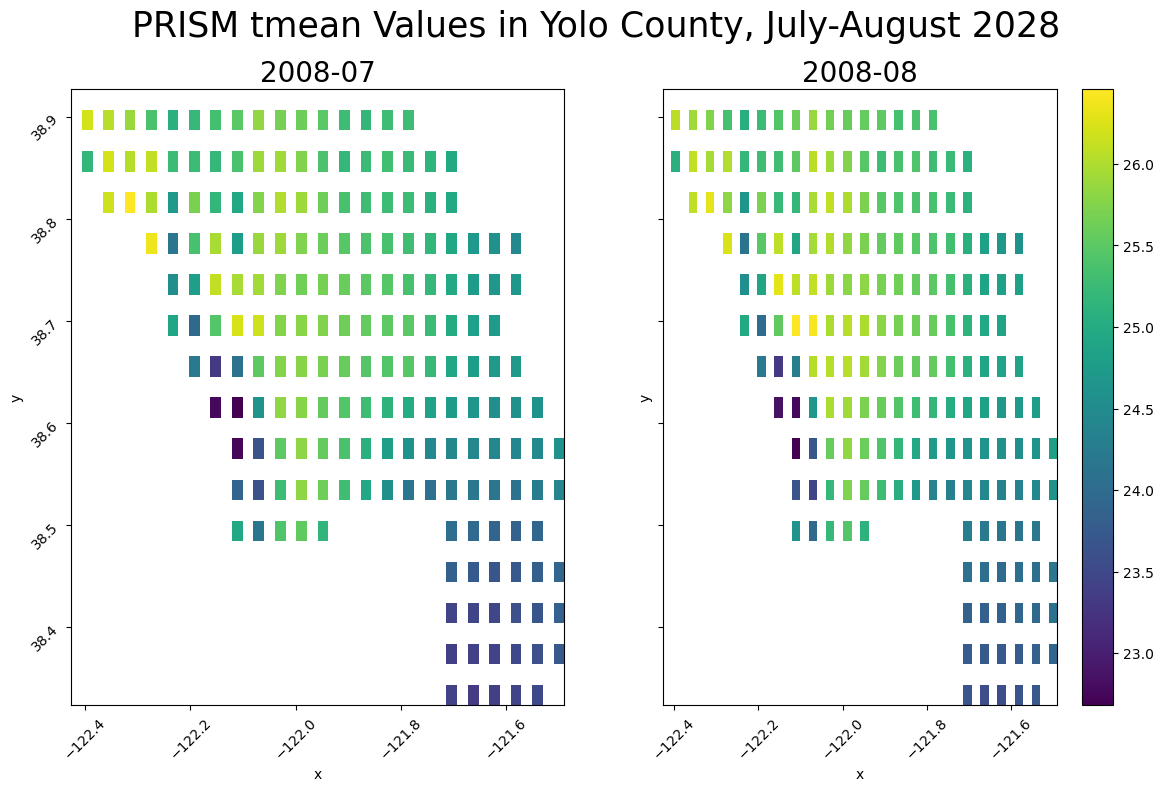

In [46]:
# Same as above, but with just PRISM requests
geom_data = yolo_county_zip_guid
dsvars = dsvars_debug
date_data = date_grain_dict1

with tempfile.TemporaryDirectory() as tf:
    output_files = pygcdl_obj.download_polygon_subset(
        dsvars=dsvars, 
        t_geom=geom_data,
        dsn=tf,
        #resolution=spat_res,
        **date_data
    )
    ppt_file_paths = [Path(f) for f in output_files if "PRISM" in f and "ppt" in f]
    tmean_file_paths = [Path(f) for f in output_files if "PRISM" in f and "tmean" in f]
    
    print(ppt_file_paths)
    print(tmean_file_paths)
    
    # Read in PRISM ppt data.
    ppt_image_stack = [
        rioxarray.open_rasterio(k, masked=True) for k in ppt_file_paths
    ]
    
    num_images = len(ppt_image_stack)
    
    ppt_layer_names = [
        str(path).split("PRISM_ppt_")[1].split(".tif")[0] for path in ppt_file_paths
    ]
    
    # Plot the PRISM ppt data.
    
    fig, axs = plt.subplots(ncols=2, figsize = (14, 8), sharey=True)
    fig.suptitle("PRISM ppt Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = ppt_image_stack[i].plot(ax=axs[i], add_colorbar=False)
        axs[i].set_title(ppt_layer_names[i], fontsize=20)
        axs[i].tick_params(labelrotation=45)
    fig.colorbar(im)
    
    # Read in PRISM tmean data.
    tmean_image_stack = [
        rioxarray.open_rasterio(k, masked=True) for k in tmean_file_paths
    ]
    
    num_images = len(tmean_image_stack)
    
    tmean_crs = tmean_image_stack[0].rio.crs
    print("tmean CRS: ", tmean_crs)
    
    tmean_layer_names = [
        str(path).split("PRISM_tmean_")[1].split(".tif")[0] for path in tmean_file_paths
    ]
    
    # Plot the PRISM tmean data.
    
    fig, axs = plt.subplots(ncols=2, figsize = (14, 8), sharey=True)
    fig.suptitle("PRISM tmean Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = tmean_image_stack[i].plot(ax=axs[i], add_colorbar=False)
        axs[i].set_title(tmean_layer_names[i], fontsize=20)
        axs[i].tick_params(labelrotation=45)
    fig.colorbar(im)

    # Close xarray images so the temporary directory can close without errors
    for image in ppt_image_stack:
        image.close()
    for image in tmean_image_stack:
        image.close()

In [36]:
dsvars_debug = pd.DataFrame(
    [["PRISM", "tmean"]], 
    columns=["dataset", "variable"])
print(dsvars_debug)

  dataset variable
0   PRISM    tmean


[WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpn8du3pb3/PRISM_tmean_2008-07.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmpn8du3pb3/PRISM_tmean_2008-08.tif')]
tmean CRS:  EPSG:4269


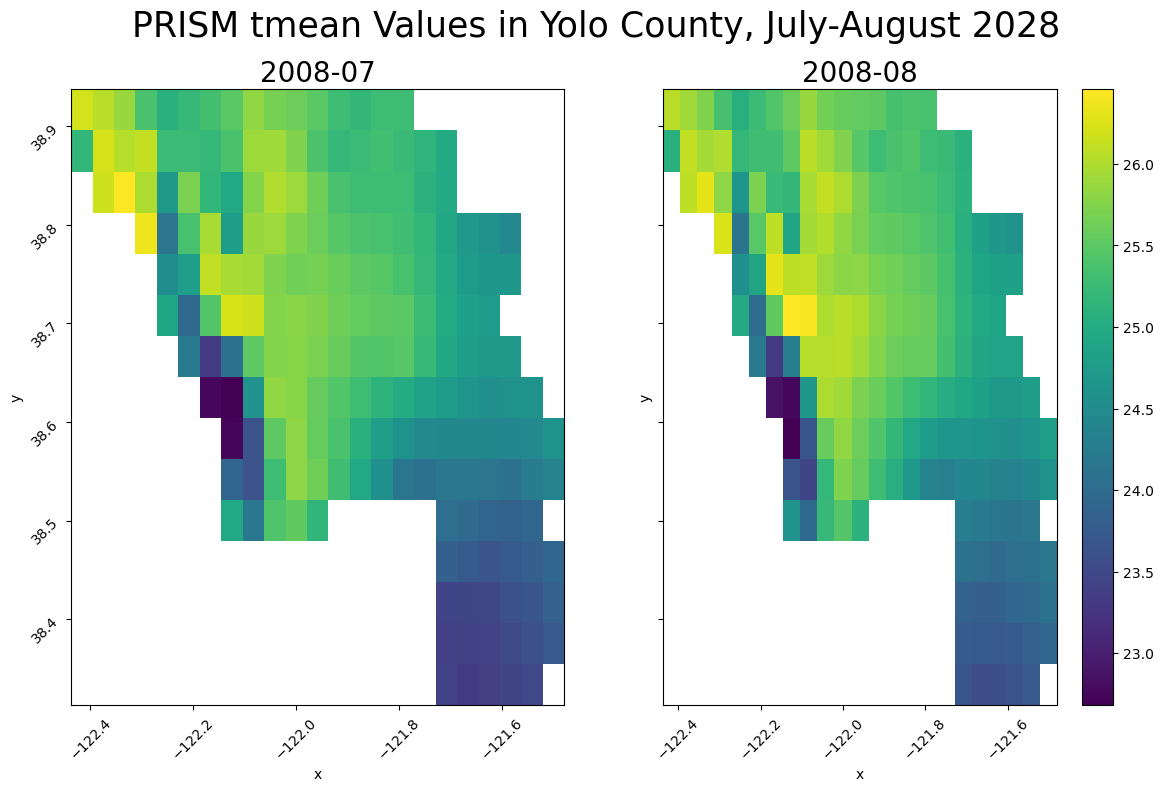

In [37]:
# Same as above, but with just tmean requests
geom_data = yolo_county_geojson_guid
dsvars = dsvars_debug
date_data = date_grain_dict1

with tempfile.TemporaryDirectory() as tf:
    output_files = pygcdl_obj.download_polygon_subset(
        dsvars=dsvars, 
        t_geom=yolo_county_zip_guid,
        dsn=tf,
        **date_data
    )
    tmean_file_paths = [Path(f) for f in output_files if "PRISM" in f and "tmean" in f]
    
    print(tmean_file_paths)
    
    
    # Read in PRISM tmean data.
    tmean_image_stack = [
        rioxarray.open_rasterio(k, masked=True) for k in tmean_file_paths
    ]
    
    num_images = len(tmean_image_stack)
    
    tmean_crs = tmean_image_stack[0].rio.crs
    print("tmean CRS: ", tmean_crs)
    
    tmean_layer_names = [
        str(path).split("PRISM_tmean_")[1].split(".tif")[0] for path in tmean_file_paths
    ]
    
    # Plot the PRISM tmean data.
    
    fig, axs = plt.subplots(ncols=2, figsize = (14, 8), sharey=True)
    fig.suptitle("PRISM tmean Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = tmean_image_stack[i].plot(ax=axs[i], add_colorbar=False)
        axs[i].set_title(tmean_layer_names[i], fontsize=20)
        axs[i].tick_params(labelrotation=45)
    fig.colorbar(im)

    # Close xarray images so the temporary directory can close without errors
    for image in tmean_image_stack:
        image.close()

In [36]:
dsvars_debug = pd.DataFrame(
    [["PRISM", "tmean"], ["PRISM", "ppt"]], 
    columns=["dataset", "variable"])
print(dsvars_debug)

  dataset variable
0   PRISM    tmean
1   PRISM      ppt


In [37]:
# Same as above, but with just PRISM requests, order switched
geom_data = yolo_county_geojson_guid
dsvars = dsvars_debug
date_data = date_grain_dict1

with tempfile.TemporaryDirectory() as tf:
    output_files = pygcdl_obj.download_polygon_subset(
        dsvars=dsvars, 
        t_geom=yolo_county_zip_guid,
        dsn=tf,
        **date_data
    )
    ppt_file_paths = [Path(f) for f in output_files if "PRISM" in f and "ppt" in f]
    tmean_file_paths = [Path(f) for f in output_files if "PRISM" in f and "tmean" in f]
    
    print(ppt_file_paths)
    print(tmean_file_paths)
    
    # Read in PRISM ppt data.
    ppt_image_stack = [
        rioxarray.open_rasterio(k, masked=True) for k in ppt_file_paths
    ]
    
    num_images = len(ppt_image_stack)
    
    ppt_layer_names = [
        str(path).split("PRISM_ppt_")[1].split(".tif")[0] for path in ppt_file_paths
    ]
    
    # Plot the PRISM ppt data.
    
    fig, axs = plt.subplots(ncols=2, figsize = (14, 8), sharey=True)
    fig.suptitle("PRISM ppt Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = ppt_image_stack[i].plot(ax=axs[i], add_colorbar=False)
        axs[i].set_title(ppt_layer_names[i], fontsize=20)
        axs[i].tick_params(labelrotation=45)
    fig.colorbar(im)
    
    # Read in PRISM tmean data.
    tmean_image_stack = [
        rioxarray.open_rasterio(k, masked=True) for k in tmean_file_paths
    ]
    
    num_images = len(tmean_image_stack)
    
    tmean_crs = tmean_image_stack[0].rio.crs
    print("tmean CRS: ", tmean_crs)
    
    tmean_layer_names = [
        str(path).split("PRISM_tmean_")[1].split(".tif")[0] for path in tmean_file_paths
    ]
    
    # Plot the PRISM tmean data.
    
    fig, axs = plt.subplots(ncols=2, figsize = (14, 8), sharey=True)
    fig.suptitle("PRISM tmean Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = tmean_image_stack[i].plot(ax=axs[i], add_colorbar=False)
        axs[i].set_title(tmean_layer_names[i], fontsize=20)
        axs[i].tick_params(labelrotation=45)
    fig.colorbar(im)

    # Close xarray images so the temporary directory can close without errors
    for image in ppt_image_stack:
        image.close()
    for image in tmean_image_stack:
        image.close()

Status_code:  500


Exception: Internal Server Error

[WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmp_tqp7xsg/MODIS_NDVI_NDVI_2008-07-07.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmp_tqp7xsg/MODIS_NDVI_NDVI_2008-07-15.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmp_tqp7xsg/MODIS_NDVI_NDVI_2008-07-23.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmp_tqp7xsg/MODIS_NDVI_NDVI_2008-07-31.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmp_tqp7xsg/MODIS_NDVI_NDVI_2008-08-08.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmp_tqp7xsg/MODIS_NDVI_NDVI_2008-08-16.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmp_tqp7xsg/MODIS_NDVI_NDVI_2008-08-24.tif')]
[WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmp_tqp7xsg/PRISM_ppt_2008-07.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmp_tqp7xsg/PRISM_ppt_2008-08.tif')]
[WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/tmp_tqp7xsg/PRISM_tmean_2008-07.tif'), WindowsPath('C:/Users/NOA~1.MIL/AppData/Local/Temp/t

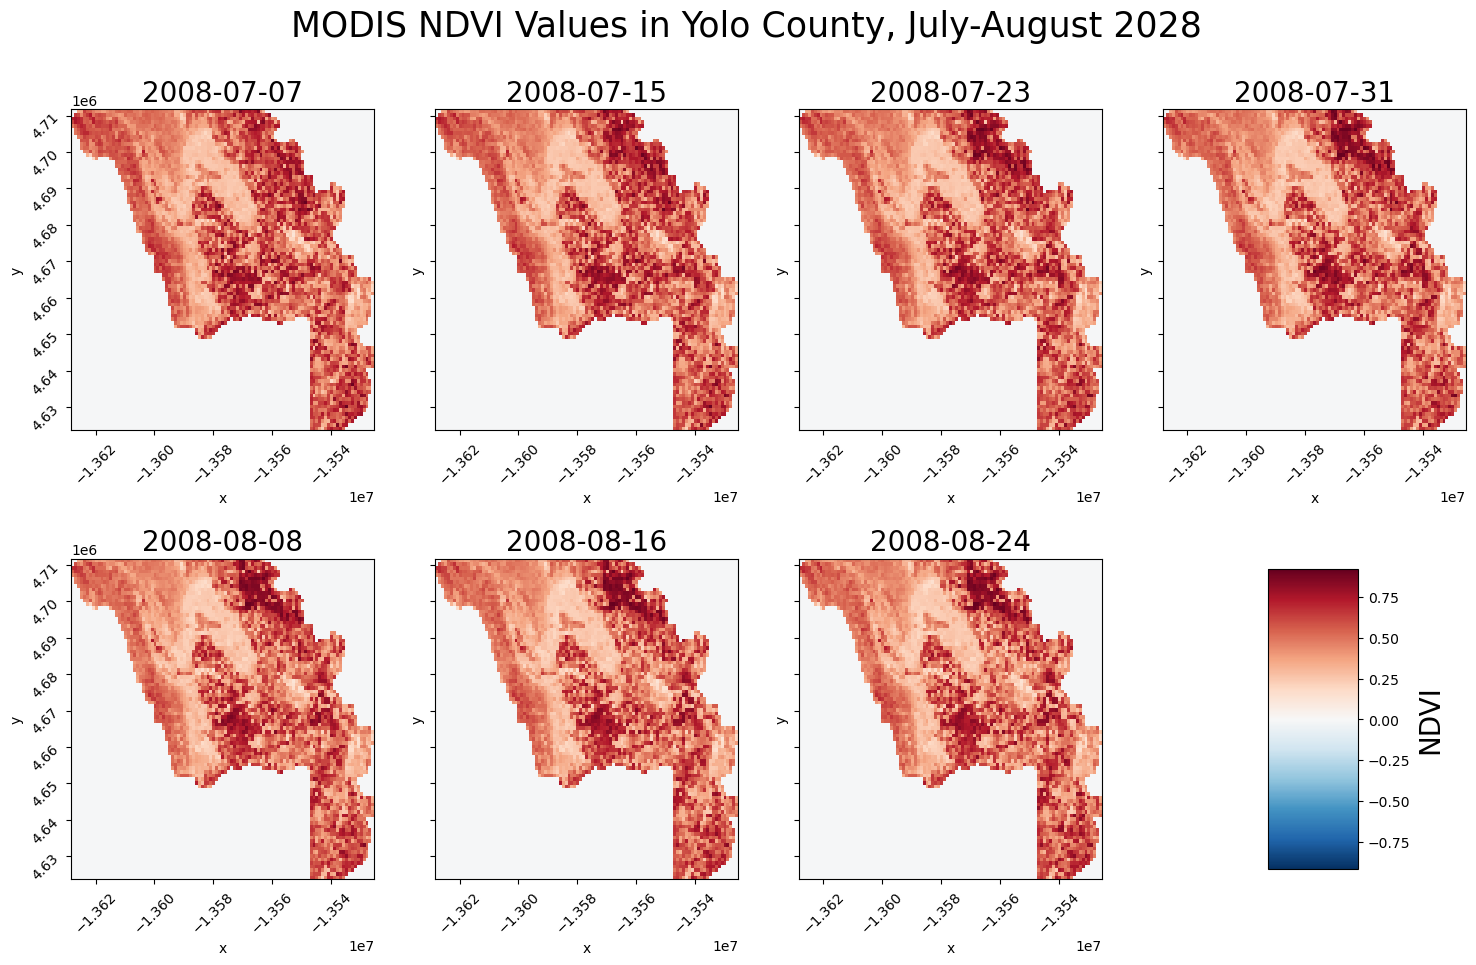

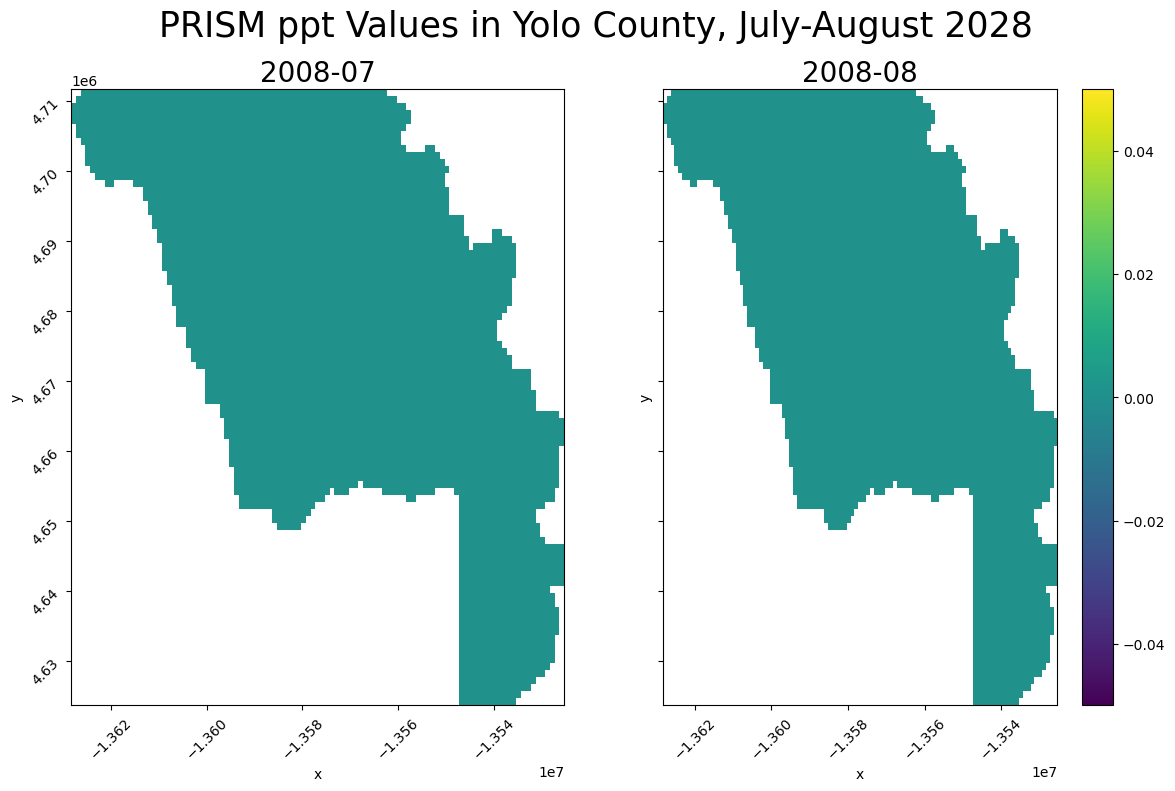

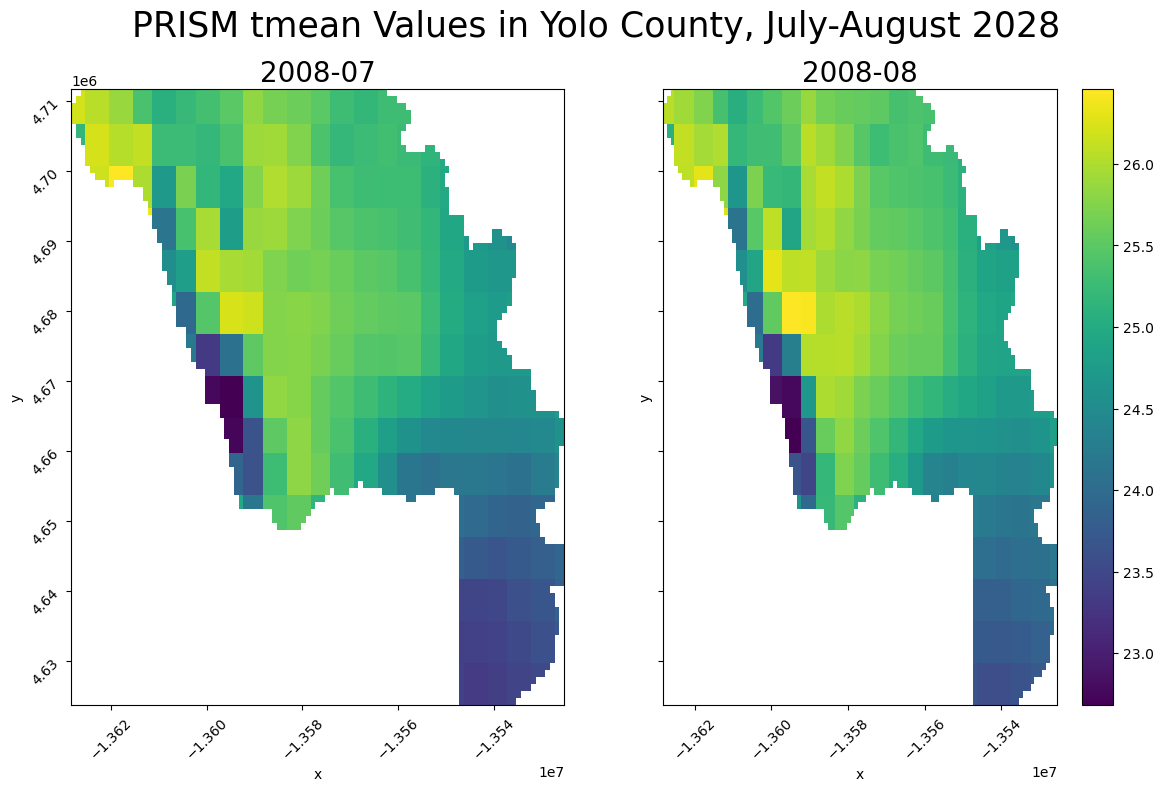

In [89]:
# Same as above, but with resolution defined
geom_data = yolo_county_geojson_guid
dsvars = dsvars1
date_data = date_grain_dict1

with tempfile.TemporaryDirectory() as tf:
    output_files = pygcdl_obj.download_polygon_subset(
        dsvars=dsvars1, 
        t_geom=yolo_county_zip_guid,
        dsn=tf,
        resolution=spat_res,
        **date_data
    )
    modis_file_paths = [Path(f) for f in output_files if "MODIS" in f]
    ppt_file_paths = [Path(f) for f in output_files if "PRISM" in f and "ppt" in f]
    tmean_file_paths = [Path(f) for f in output_files if "PRISM" in f and "tmean" in f]
    
    print(modis_file_paths)
    print(ppt_file_paths)
    print(tmean_file_paths)

    # Read in MODIS NDVI data.
    modis_image_stack = [
        rioxarray.open_rasterio(k, mask_and_scale=True) for k in modis_file_paths
    ]
    
    num_images = len(modis_image_stack)
    
    modis_crs = modis_image_stack[0].rio.crs
    print("MODIS CRS: ", modis_crs)
    
    ndvi_layer_names = [
        str(path).split("NDVI_NDVI_")[1].split(".tif")[0] for path in modis_file_paths
    ]
    
    # Plot the MODIS NDVI data.
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (18, 10), sharey=True)
    fig.suptitle("MODIS NDVI Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = modis_image_stack[i].plot(ax=axs[math.floor(i/4), i%4], add_colorbar=False)
        axs[math.floor(i/4), i%4].set_title(ndvi_layer_names[i], fontsize=20)
        axs[math.floor(i/4), i%4].tick_params(labelrotation=45)
    axs[1,3].axis("off")
    label_axis = fig.add_axes([0.79, 0.12, 0.05, 0.3])
    cbar = fig.colorbar(im, cax=label_axis)
    cbar.set_label(label="NDVI", fontsize=20)
    
    # Read in PRISM ppt data.
    ppt_image_stack = [
        rioxarray.open_rasterio(k, masked=True) for k in ppt_file_paths
    ]
    
    num_images = len(ppt_image_stack)
    
    ppt_crs = ppt_image_stack[0].rio.crs
    print("ppt CRS: ", ppt_crs)
    ppt_layer_names = [
        str(path).split("PRISM_ppt_")[1].split(".tif")[0] for path in ppt_file_paths
    ]
    
    # Plot the PRISM ppt data.
    
    fig, axs = plt.subplots(ncols=2, figsize = (14, 8), sharey=True)
    fig.suptitle("PRISM ppt Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = ppt_image_stack[i].plot(ax=axs[i], add_colorbar=False)
        axs[i].set_title(ppt_layer_names[i], fontsize=20)
        axs[i].tick_params(labelrotation=45)
    fig.colorbar(im)
    
    # Read in PRISM tmean data.
    tmean_image_stack = [
        rioxarray.open_rasterio(k, masked=True) for k in tmean_file_paths
    ]
    
    num_images = len(tmean_image_stack)
    
    tmean_crs = tmean_image_stack[0].rio.crs
    print("tmean CRS: ", tmean_crs)
    
    tmean_layer_names = [
        str(path).split("PRISM_tmean_")[1].split(".tif")[0] for path in tmean_file_paths
    ]

    # Plot the PRISM tmean data.
    
    fig, axs = plt.subplots(ncols=2, figsize = (14, 8), sharey=True)
    fig.suptitle("PRISM tmean Values in Yolo County, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = tmean_image_stack[i].plot(ax=axs[i], add_colorbar=False)
        axs[i].set_title(tmean_layer_names[i], fontsize=20)
        axs[i].tick_params(labelrotation=45)
    fig.colorbar(im)

    # Close xarray images so the temporary directory can close without errors
    for image in modis_image_stack:
        image.close()
    for image in ppt_image_stack:
        image.close()
    for image in tmean_image_stack:
        image.close()